# Deep Learning for Detecting Pneumonia from X-ray Images

## Convolutional Neural Network

Building an algorithm to automatically identify whether a patient is suffering from pneumonia or not by looking at chest X-ray images.
The accuracy of the model built is extremely important as lives of people is at stake.

The minimum accuracy accepted is 90%.

## I - Imports

In [5]:
import os
import numpy as np
import pandas as pd 
import random
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from sklearn.metrics import accuracy_score, confusion_matrix

seed = 232
np.random.seed(seed)
tf.random.set_seed(seed)

## II - Load datasets

**Dataset Normal/Pneumonia**

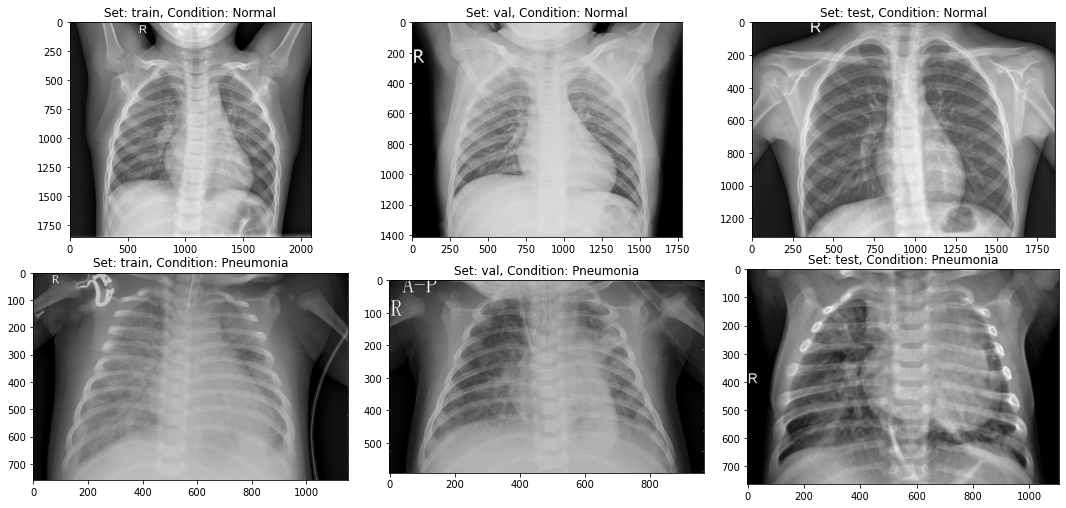

In [6]:
input_path = './dataset/'

fig, ax = plt.subplots(2, 3, figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train', 'val', 'test']):
    set_path = input_path+_set
    ax[i].imshow(plt.imread(set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL')[0]), cmap='gray')
    ax[i].set_title('Set: {}, Condition: Normal'.format(_set))
    ax[i+3].imshow(plt.imread(set_path+'/PNEUMONIA/'+os.listdir(set_path+'/PNEUMONIA')[0]), cmap='gray')
    ax[i+3].set_title('Set: {}, Condition: Pneumonia'.format(_set))

In [7]:
for _set in ['train', 'val', 'test']:
    n_normal = len(os.listdir(input_path + _set + '/NORMAL'))
    n_infect = len(os.listdir(input_path + _set + '/PNEUMONIA'))
    print('Set: {}, normal images: {}, pneumonia images: {}'.format(_set, n_normal, n_infect))

Set: train, normal images: 1341, pneumonia images: 3875
Set: val, normal images: 8, pneumonia images: 8
Set: test, normal images: 234, pneumonia images: 390


**Dataset Bacteria/Virus**

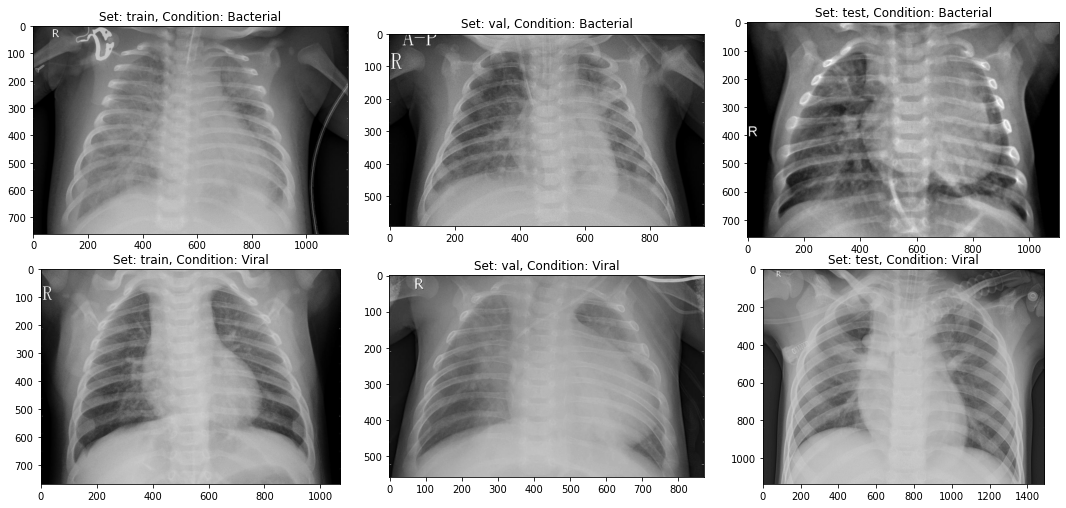

In [8]:
input_path_pmn = './dataset_pmn/'

fig, ax = plt.subplots(2, 3, figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train', 'val', 'test']):
    set_path = input_path_pmn+_set
    ax[i].imshow(plt.imread(set_path+'/BACTERIA/'+os.listdir(set_path+'/BACTERIA')[0]), cmap='gray')
    ax[i].set_title('Set: {}, Condition: Bacterial'.format(_set))
    ax[i+3].imshow(plt.imread(set_path+'/VIRUS/'+os.listdir(set_path+'/VIRUS')[0]), cmap='gray')
    ax[i+3].set_title('Set: {}, Condition: Viral'.format(_set))

In [9]:
for _set in ['train', 'val', 'test']:
    n_normal = len(os.listdir(input_path_pmn + _set + '/BACTERIA'))
    n_infect = len(os.listdir(input_path_pmn + _set + '/VIRUS'))
    print('Set: {}, normal images: {}, pneumonia images: {}'.format(_set, n_normal, n_infect))

Set: train, normal images: 2530, pneumonia images: 1345
Set: val, normal images: 8, pneumonia images: 8
Set: test, normal images: 242, pneumonia images: 148


## III - Create the model

In [ ]:
img_dims = 200
epochs = 10
batch_size = 32

In [11]:
inputs = Input(shape=(img_dims, img_dims, 3))

# First conv block
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Second conv block
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Third conv block
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Fourth conv block
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# Fifth conv block
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# FC layer
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.7)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.3)(x)

# Output layer
output = Dense(units=1, activation='sigmoid')(x)

## IV - Normal/Pneumonia Model

### 1 - Process data

In [12]:
def process_data(img_dims, batch_size):
    #
    train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, vertical_flip=True)
    test_val_datagen = ImageDataGenerator(rescale=1./255)
    
    # 
    train_gen = train_datagen.flow_from_directory(
        directory=input_path+'train', 
        target_size=(img_dims, img_dims), 
        batch_size=batch_size, 
        class_mode='binary', 
        shuffle=True)

    test_gen = test_val_datagen.flow_from_directory(
        directory=input_path+'test', 
        target_size=(img_dims, img_dims), 
        batch_size=batch_size, 
        class_mode='binary', 
        shuffle=True)
    
    #
    test_data = []
    test_labels = []

    #
    for cond in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(input_path + 'test' + cond)):
            img = plt.imread(input_path+'test'+cond+img)
            img = cv2.resize(img, (img_dims, img_dims))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if cond=='/NORMAL/':
                label = 0
            elif cond=='/PNEUMONIA/':
                label = 1
            test_data.append(img)
            test_labels.append(label)
        
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    
    return train_gen, test_gen, test_data, test_labels

In [13]:
train_gen, test_gen, test_data, test_labels = process_data(img_dims, batch_size)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


### 2 - Train Model

In [14]:
# Creating model and compiling
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

In [15]:
hist = model.fit(
           train_gen, steps_per_epoch=train_gen.samples // batch_size, 
           epochs=epochs, validation_data=test_gen, 
           validation_steps=test_gen.samples // batch_size, callbacks=[checkpoint, lr_reduce])

C:\Users\gusta\AppData\Local\Temp/ipykernel_7716/2276952013.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


Epoch 1/10
163/163 [==============================] - 198s 1s/step - loss: 0.3531 - accuracy: 0.8414 - val_loss: 0.7856 - val_accuracy: 0.6234 - lr: 0.0010
Epoch 2/10
163/163 [==============================] - 173s 1s/step - loss: 0.2786 - accuracy: 0.8846 - val_loss: 1.0108 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 3/10
163/163 [==============================] - 167s 1s/step - loss: 0.2332 - accuracy: 0.9026 - val_loss: 2.6583 - val_accuracy: 0.6283 - lr: 0.0010
Epoch 4/10
163/163 [==============================] - 156s 955ms/step - loss: 0.2261 - accuracy: 0.9164 - val_loss: 2.5212 - val_accuracy: 0.6217 - lr: 0.0010
Epoch 5/10
163/163 [==============================] - ETA: 0s - loss: 0.2074 - accuracy: 0.9179
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 165s 1s/step - loss: 0.2074 - accuracy: 0.9179 - val_loss: 0.6657 - val_accuracy: 0.6464 - lr: 0.0010
Epoch 6/10
163/163 [==============================] - 16

### 3 - Metrics, stats and confusion matrix

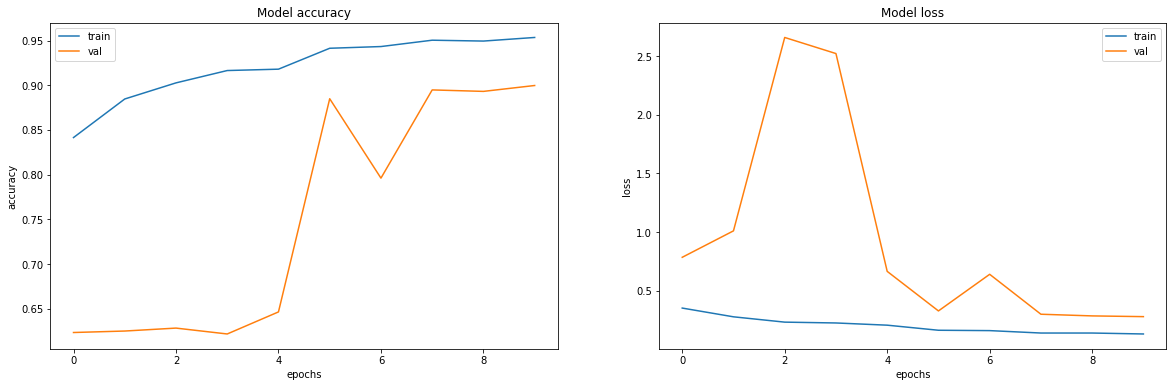

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [17]:
preds = model.predict(test_data)

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((hist.history['accuracy'][-1])*100, 2)))

CONFUSION MATRIX ------------------
[[186  48]
 [ 19 371]]

TEST METRICS ----------------------
Accuracy: 89.26282051282051%
Precision: 88.54415274463007%
Recall: 95.12820512820512%
F1-score: 91.71817058096416

TRAIN METRIC ----------------------
Train acc: 95.34


## V - Bacteria/Virus Model

### 1 - Process data

In [18]:
def process_data_pmn(img_dims, batch_size):
    #
    train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, vertical_flip=True)
    test_val_datagen = ImageDataGenerator(rescale=1./255)
    
    # 
    train_gen_pmn = train_datagen.flow_from_directory(
        directory=input_path_pmn+'train', 
        target_size=(img_dims, img_dims), 
        batch_size=batch_size, 
        class_mode='binary', 
        shuffle=True)

    test_gen_pmn = test_val_datagen.flow_from_directory(
        directory=input_path_pmn+'test', 
        target_size=(img_dims, img_dims), 
        batch_size=batch_size, 
        class_mode='binary', 
        shuffle=True)
    
    #
    test_data_pmn = []
    test_labels_pmn = []

    #
    for cond in ['/BACTERIA/', '/VIRUS/']:
        for img in (os.listdir(input_path_pmn + 'test' + cond)):
            img = plt.imread(input_path_pmn+'test'+cond+img)
            img = cv2.resize(img, (img_dims, img_dims))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if cond=='/BACTERIA/':
                label = 0
            elif cond=='/VIRUS/':
                label = 1
            test_data_pmn.append(img)
            test_labels_pmn.append(label)
        
    test_data_pmn = np.array(test_data)
    test_labels_pmn = np.array(test_labels)
    
    return train_gen_pmn, test_gen_pmn, test_data_pmn, test_labels_pmn

In [ ]:
img_dims = 200
epochs = 10
batch_size = 32

In [19]:
train_gen_pmn, test_gen_pmn, test_data_pmn, test_labels_pmn = process_data_pmn(img_dims, batch_size)

Found 3875 images belonging to 2 classes.
Found 390 images belonging to 2 classes.


### 2 - Train Model

In [20]:
# Creating model and compiling
model_pmn = Model(inputs=inputs, outputs=output)
model_pmn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint_pmn = ModelCheckpoint(filepath='best_weights_pmn.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce_pmn = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop_pmn = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

In [21]:
hist_pmn = model_pmn.fit(
           train_gen_pmn, steps_per_epoch=train_gen_pmn.samples // batch_size, 
           epochs=epochs, validation_data=test_gen_pmn, 
           validation_steps=test_gen_pmn.samples // batch_size, callbacks=[checkpoint_pmn, lr_reduce_pmn])

C:\Users\gusta\AppData\Local\Temp/ipykernel_7716/1613877409.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist_pmn = model_pmn.fit_generator(


Epoch 1/10
121/121 [==============================] - 124s 1s/step - loss: 0.6767 - accuracy: 0.6680 - val_loss: 0.6042 - val_accuracy: 0.8672 - lr: 0.0010
Epoch 2/10
121/121 [==============================] - 147s 1s/step - loss: 0.5817 - accuracy: 0.7174 - val_loss: 0.7436 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 3/10
121/121 [==============================] - 151s 1s/step - loss: 0.5701 - accuracy: 0.7398 - val_loss: 0.6133 - val_accuracy: 0.6224 - lr: 0.0010
Epoch 4/10
121/121 [==============================] - ETA: 0s - loss: 0.5640 - accuracy: 0.7361
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
121/121 [==============================] - 149s 1s/step - loss: 0.5640 - accuracy: 0.7361 - val_loss: 0.4852 - val_accuracy: 0.8672 - lr: 0.0010
Epoch 5/10
121/121 [==============================] - 146s 1s/step - loss: 0.5480 - accuracy: 0.7476 - val_loss: 0.4399 - val_accuracy: 0.8021 - lr: 3.0000e-04
Epoch 6/10
121/121 [==============================] - E

### 3 - Metrics, stats and confusion matrix

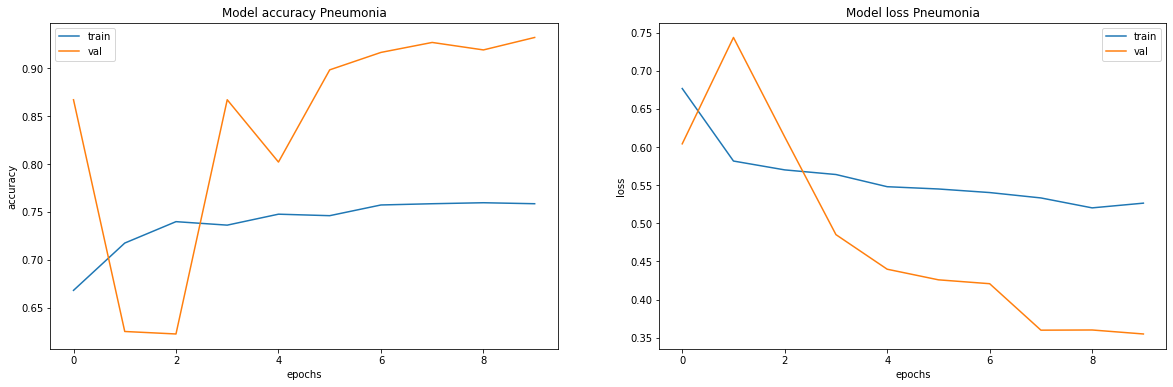

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist_pmn.history[met])
    ax[i].plot(hist_pmn.history['val_' + met])
    ax[i].set_title('Model {} Pneumonia'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [23]:
preds_pmn = model_pmn.predict(test_data_pmn)

acc_pmn = accuracy_score(test_labels_pmn, np.round(preds_pmn))*100
cm_pmn = confusion_matrix(test_labels_pmn, np.round(preds_pmn))
tn_pmn, fp_pmn, fn_pmn, tp_pmn = cm_pmn.ravel()

print('CONFUSION MATRIX ------------------')
print(cm_pmn)

print('\nTEST METRICS ----------------------')
precision_pmn = tp_pmn/(tp_pmn+fp_pmn)*100
recall_pmn = tp_pmn/(tp_pmn+fn_pmn)*100
print('Accuracy: {}%'.format(acc_pmn))
print('Precision: {}%'.format(precision_pmn))
print('Recall: {}%'.format(recall_pmn))
print('F1-score: {}'.format(2*precision_pmn*recall_pmn/(precision_pmn+recall_pmn)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((hist_pmn.history['accuracy'][-1])*100, 2)))

CONFUSION MATRIX ------------------
[[140  94]
 [267 123]]

TEST METRICS ----------------------
Accuracy: 42.1474358974359%
Precision: 56.68202764976959%
Recall: 31.538461538461537%
F1-score: 40.527182866556835

TRAIN METRIC ----------------------
Train acc: 75.85


## VI - Combine models

The purpose of this program is, given the chest x-ray images of a person, determine if he/she has pneumonia and, if yes, if the pneumonia is viral or bacterial in origin.

### 1 - Enter the path to the chest x-ray image

In [24]:
chest_xray = ''

### 2 - Process the image

In [25]:
#TODO: Process the images to send it to the algorithm

### 3 - Algorithm

In [26]:
#TODO: Use the models created above to create the algo

### 4 - Result

In [27]:
#TODO: Use the algo with the image given to determine if the person is going to die